N= 2, τ=0.010, Erg / <EB> =1.000000
N= 4, τ=0.010, Erg / <EB> =0.999999
N= 6, τ=0.010, Erg / <EB> =0.999997
N= 8, τ=0.010, Erg / <EB> =0.999994
N=10, τ=0.010, Erg / <EB> =0.999988
N=12, τ=0.010, Erg / <EB> =0.999980
N=14, τ=0.010, Erg / <EB> =0.999970
N=16, τ=0.010, Erg / <EB> =0.999956
N=18, τ=0.010, Erg / <EB> =0.999936


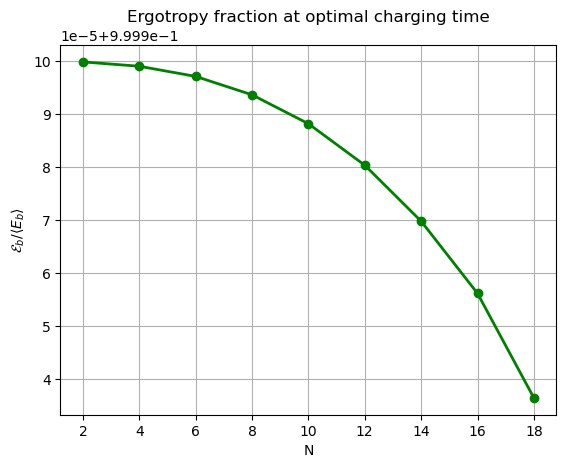

In [13]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

############
# parameters
############

N_arr = np.arange(2, 20, 2)
nmax = 20
ω = 1.0
ω0 = 1.0
g = 1.0
tlist = np.arange(0.01, 2*np.pi, 0.1)

######################
# collective operators
######################

def collective_ops(N):
    Sp = qt.jmat(N/2, '+')
    Sm = Sp.dag()
    Sz = qt.jmat(N/2, 'z')
    HB = Sz + (N/2)*qt.qeye(N+1)
    return Sp, Sm, HB

############################
# Tavis-Cummings Hamiltonian
############################

def tavis_cummings(N, nmax, ω, ω0, g):
    a = qt.destroy(nmax)
    Sp, Sm, HB = collective_ops(N)
    H = (ω * qt.tensor(a.dag()*a, qt.qeye(N+1)) + ω0 * qt.tensor(qt.qeye(nmax), HB) + g * (qt.tensor(a, Sp) + qt.tensor(a.dag(), Sm)))
    return H, HB

################
# Initial state
################

def initial_state(N, nmax, state):
    if state=="coherent":
        psiA = qt.coherent(nmax, np.sqrt(N))
    elif state=="fock":
        psiA = qt.basis(nmax, N)
    psiB = qt.basis(N+1, 0)  
    return qt.tensor(psiA, psiB)

#########################################
# optimal charging time τ (maximum power)
#########################################

τ_list = []

for N in N_arr:
    H, HB = tavis_cummings(N, nmax, ω, ω0, g)
    HB_full = qt.tensor(qt.qeye(nmax), HB)
    psi0 = initial_state(N, nmax, "fock")

    res = qt.sesolve(H, psi0, tlist, e_ops=HB_full)
    EB = np.array(res.expect[0])
    power = EB / tlist

    τ_list.append(tlist[np.argmax(power)])

###########################################
# Calculation of ergotropy and fluctuations
###########################################

E_ratio, F_ratio = [], []

for i, N in enumerate(N_arr):

    τ = τ_list[i]
    
    H, HB = tavis_cummings(N, nmax, ω, ω0, g)
    
    psi0 = initial_state(N, nmax, "fock")

    opts = qt.Options(nsteps=10000)
    res = qt.sesolve(H, psi0, [0, τ], options=opts)
    
    rho_b = res.states[-1].proj().ptrace(1)
    

    E_B = qt.expect(HB, rho_b)
    
    r_vals, r_vecs = rho_b.eigenstates()
    
    r_vecs = np.sort(rho_b.eigenenergies())[::-1]
    
    # Passive Hamiltonian constructed in the passive state's eigenbasis
    
    e_vals, e_vecs = HB.eigenstates()
    
    H_passive = sum(e_vals[i] * r_vecs[i] * r_vecs[i].conj().T for i in range(len(e_vals)))

    # Ergotropy operator defined w.r.t. passive Hamiltonian
    
    E_op = HB - H_passive
    
    E_B = qt.expect(HB, rho_b)
    
    E_erg = qt.expect(E_op, rho_b)
    
    ΔE = np.sqrt(qt.expect(E_op**2, rho_b) - E_erg**2)

    E_ratio.append(E_erg / E_B)
    
    F_ratio.append(ΔE / E_erg)

for idx, N in enumerate(N_arr):
    print(f"N={N:2d}, τ={τ_list[idx]:.3f}, Erg / <EB> ={E_ratio[idx]:.6f}")


##########################################################
# Plot ergotropy fraction as function of g for different N 
##########################################################

plt.plot(N_arr, E_ratio, 'o-', color='g', linewidth=2)
plt.xlabel("N")
plt.ylabel(r"$\mathcal{E}_b / \langle E_b \rangle$")
plt.title("Ergotropy fraction at optimal charging time")
plt.grid(True)
plt.show()

N= 2, τ=0.010, Relative Fluctuation =0.012249
N= 4, τ=0.010, Relative Fluctuation =0.011184
N= 6, τ=0.010, Relative Fluctuation =0.010807
N= 8, τ=0.010, Relative Fluctuation =0.010615
N=10, τ=0.010, Relative Fluctuation =0.010498
N=12, τ=0.010, Relative Fluctuation =0.010421
N=14, τ=0.010, Relative Fluctuation =0.010365
N=16, τ=0.010, Relative Fluctuation =0.010324
N=18, τ=0.010, Relative Fluctuation =0.010061


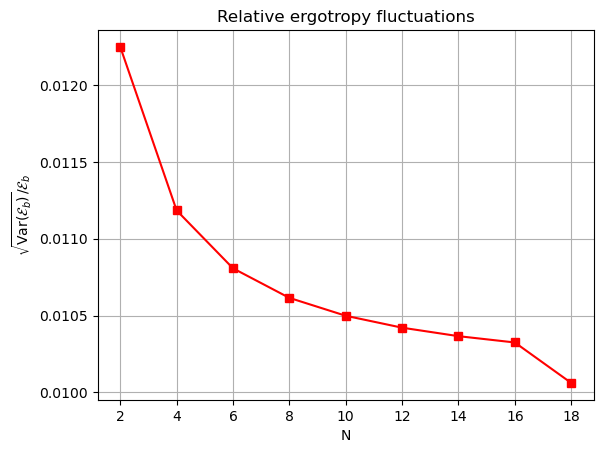

In [8]:
###################################################
# Plot variance as a function of g for different N 
###################################################

for idx, N in enumerate(N_arr):
    print(f"N={N:2d}, τ={τ_list[idx]:.3f}, Relative Fluctuation ={F_ratio[idx]:.6f}")


plt.plot(N_arr, F_ratio, 's-', color='r')
plt.xlabel("N")
plt.ylabel(r"$\sqrt{\mathrm{Var}(\mathcal{E}_b)}/\mathcal{E}_b$")
plt.title("Relative ergotropy fluctuations")
plt.grid(True)
plt.show()

In [9]:
################################################################
# commutator test: ρ is diagonal or not in the energy eigenbasis
################################################################

comm = rho_b * HB - HB * rho_b
comm_norm = comm.norm()
print("[rho, HB]=", comm_norm)

[rho, HB]= 0.0


In [10]:
##################################
# numerical degeneracy check of HB 
##################################

e_vals = np.array(HB.eigenenergies())
tol = 1e-10

degenerate_levels = []
for i in range(len(e_vals)-1):
    if abs(e_vals[i+1] - e_vals[i]) < tol:
        degenerate_levels.append((i, i+1))

print("Degenerate pairs:", degenerate_levels)

Degenerate pairs: []


In [11]:
#######################
# Diagonalization of HB
#######################
e_vals, e_vecs = HB.eigenstates()

######################################
# unitary matrix U (energy eigenbasis)
######################################

U = qt.Qobj(np.column_stack([v.full() for v in e_vecs]), dims=HB.dims)

##############################
# Rotate rho into energy basis
##############################

rho_energy = U.dag() * rho_b * U

M = np.abs(rho_energy.full())
np.fill_diagonal(M, 0)
print("Max off-diagonal element:", M.max())

Max off-diagonal element: 0.0


In [12]:
##########################################
# non-zero values of off-diagonal elements
##########################################

rho_mat = rho_energy.full()
dim = rho_mat.shape[0]

tol = 1e-10  # numerical threshold
offdiag_entries = []

for i in range(dim):
    for j in range(dim):
        if i != j and abs(rho_mat[i, j]) > tol:
            offdiag_entries.append((i, j, rho_mat[i, j]))

print(f"Number of non-zero off-diagonal elements: {len(offdiag_entries)}")

# Print the non-zero values

offdiag_entries_sorted = sorted(
    offdiag_entries, key=lambda x: abs(x[2]), reverse=True
)

for i, j, val in offdiag_entries_sorted[:20]:
    print(f"(i={i}, j={j})  |ρ|={abs(val):.3e}  phase={np.angle(val):+.2f}")


Number of non-zero off-diagonal elements: 0
